# Introduction 

In this Blog Post I create a logistic regression model to predict the probability of a individual being accepted or rejected for a loan based on the features provided in the dataset. I find that the model has an accuracy of around 84% with an expected profit per loan of `$1717.02`

# Grabbing the Data

The dataset below will be the one I use for this blog post:

In [25]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df = pd.read_csv(url)

## Visualizations of the Data



For the dataset, I created two plots and one summary table in order to contextualize the data. 

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns


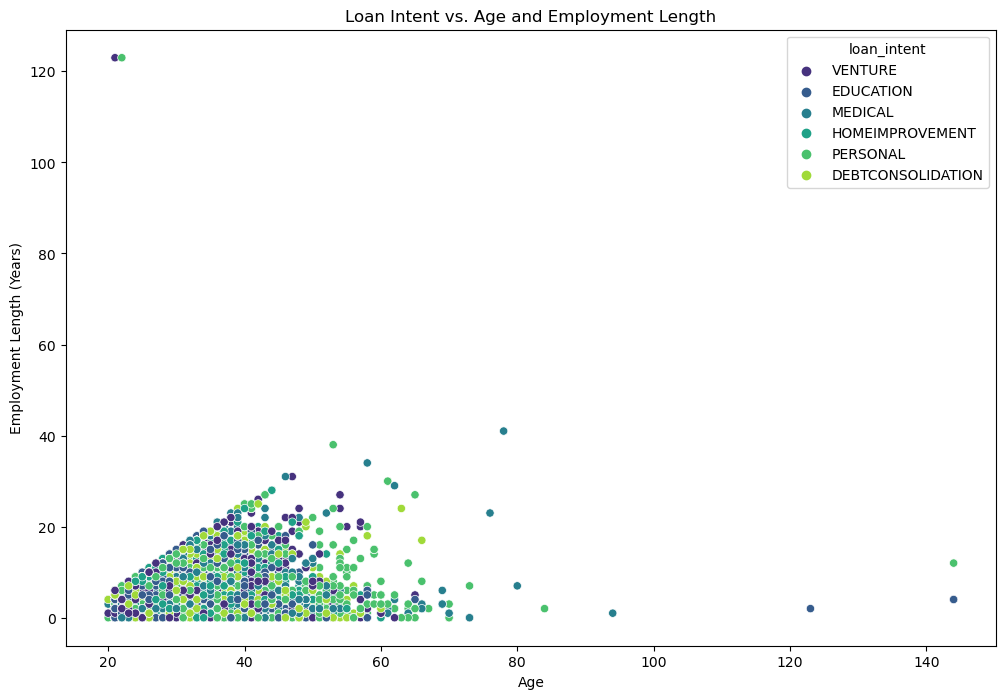

In [3]:
#| label: fig-scatter-loan
#| fig-cap: Loan Intent 

plt.figure(figsize=(12, 8))
sns.scatterplot(x='person_age', y='person_emp_length', hue='loan_intent', data=df, palette='viridis')
plt.title('Loan Intent vs. Age and Employment Length')
plt.xlabel('Age')
plt.ylabel('Employment Length (Years)')
plt.show()

Regarding @fig-scatter-loan, we can see some patterns within the dataset among loan intentions. 

Most notably in the bottom left corner of the plot, which indicates both a young age and limited employment history, there is a culmination of both Educational and Venture loans being used. 

This makes sense given the current context of the world, as young individuals would most likely be in college or other forms of education at this time. On a similar note, venture capital is often used for newly formed or aspiring companies. Hence, the youthful age and lack of employment history match.

Conversely, as age increases, loans for medical, home improvement, and debt consolidation become more likely. This evidence is runs concurrent with today's societal concerns from our more elderly population. 

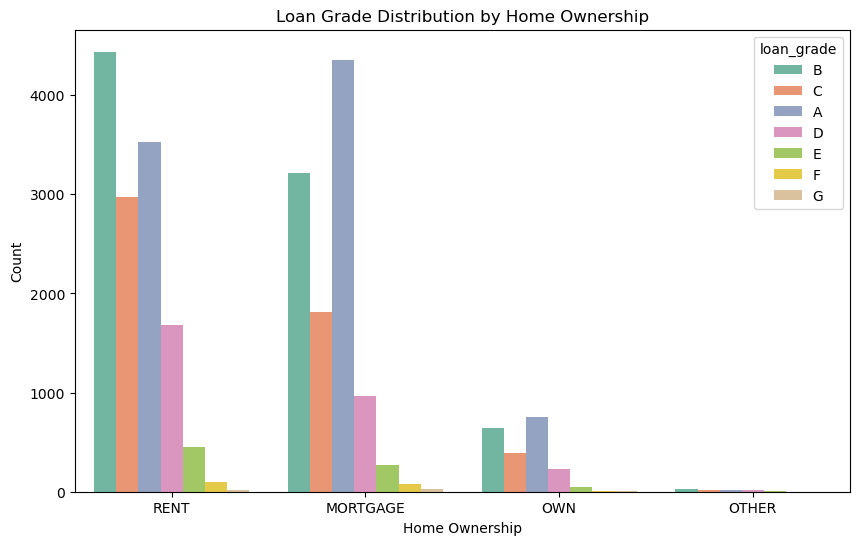

In [4]:
#| label: fig-scatter-loan-grade
#| fig-cap: Loan Grade Distribution by Home Ownership

plt.figure(figsize=(10, 6))
sns.countplot(x='person_home_ownership', hue='loan_grade', data=df, palette='Set2')
plt.title('Loan Grade Distribution by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()

@fig-scatter-loan-grade illustrates the Loan grade distribution by home ownership. Loan Grade is viewed A-G with A being the highest loan grade and G being the lowest. 

An interesting observation to make here is that for individuals in both the 'Mortgage' and 'Home' groups, the highest frequency of loans is rated as an A whereas for individuals in the 'Rent' group the highest frequency of loans is rated as an B.

This could give context to the economic state of home ownership and bank trust. Those with a mortgage/own property could perhaps be linked to being more trustworthy due to having a longer term connection with a property. Banks may view those in the 'Rent' category as a bit more risky due to the short term ability of renting.

In [5]:
summary_table = df.groupby('loan_intent').agg({
    'loan_int_rate': 'mean',
    'loan_amnt': 'mean'
}).reset_index()

summary_table.rename(columns={
    'loan_int_rate': 'Average Interest Rate',
    'loan_amnt': 'Average Loan Amount'
}, inplace=True)

print(summary_table)


         loan_intent  Average Interest Rate  Average Loan Amount
0  DEBTCONSOLIDATION              10.983305          9620.901149
1          EDUCATION              10.965465          9460.015604
2    HOMEIMPROVEMENT              11.160075         10348.725017
3            MEDICAL              11.051946          9242.269907
4           PERSONAL              11.009814          9549.427178
5            VENTURE              10.940866          9516.417425


This summary table above displays the relative average interest rates and average loan amounts for each category of loan intent.

Home improvement has the greatest average loan amount while similarly having the highest interest rate. On the flip side, education has the lowest average loan amount but the second lowest interest rate.

## Part C: Build a Model

I will be utilizing a Logistic Regression Model for predicting whether a prospective borrower is likely to default on a given loan. 

I will use my findings from the previous section to help me determine which features to include in my model. Let's begin with `loan_int_rate` and `loan_amnt` as they are the most likely to be correlated with the likelihood of defaulting on a loan.

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

y_train = df_train['loan_status']
X_train = df_train.drop(['loan_status', 'loan_grade'], axis = 1)

qual_cols = list(X_train.select_dtypes(exclude=['number']).columns)
X_train = pd.get_dummies(X_train,
                          columns = qual_cols)

want_cols = ['loan_int_rate', 'loan_amnt']

LR = LogisticRegression()
cross_val_score(LR, X_train[want_cols], y_train, cv = 5).mean()

0.7849438872731398

A score of around 79% is a good starting point for this model. However, I will be looking to improve this score by adding more features to the model. Through various combinations and manual testing we found that adding `loan_percent_income` and `person_home_ownership`, and removing `loan_amnt` to the model has an increase in accuracy as shown below:

In [91]:
cols = ['loan_percent_income', 'loan_int_rate', 'person_home_ownership_MORTGAGE',
  'person_home_ownership_OTHER',
  'person_home_ownership_OWN',
  'person_home_ownership_RENT']

LR.fit(X_train[cols], y_train)
score = LR.score(X_train[cols], y_train)

score

0.8473429107899219

With a score of around 85%, adding these two features increases our accuracy by almost 7% which is a significant improvement. Let's find the weights for these coefficients to see which features are the most important in predicting whether a borrower will default on a loan.

In [92]:
w = LR.coef_[0]
w

array([ 8.26009318, 20.76145371, -0.07428677,  0.36353638, -1.18076269,
        0.89253454])

Using these weights, let's determine the linear score function. Recall that the linear score function is given by:

$s_i = \langle \mathbf{X}_i, \mathbf{w} \rangle$

where $\mathbf{X}_i$ is the feature vector for the i-th data point and $\mathbf{w}$ is the weight vector.

We can code this as:

In [93]:
def linear_score(X, w):
    return X@w

With a score function in place, we can now give each borrower a particular score and test thresholds by profit to determine the best threshold for our model:

/Users/donovanwood/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/donovanwood/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


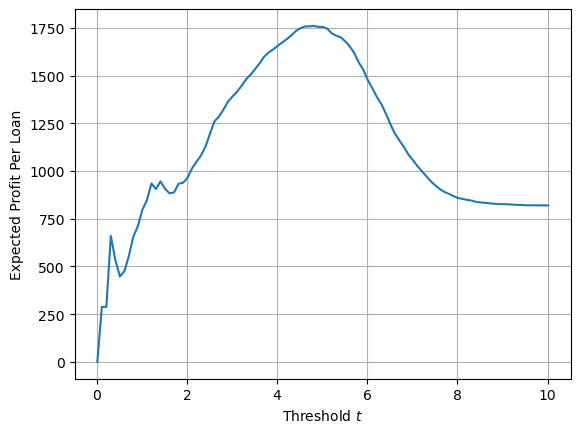

In [94]:
num_thresholds = 101
profit = np.zeros(num_thresholds)

s = linear_score(X_train[cols], w)
T = np.linspace(s.min()-0.1, s.max()+0.1, num_thresholds)
for i in range(num_thresholds):
    y_pred = s >= T[i]
    TN = X_train[((y_pred == 0) & (y_train == 0))]
    FN = X_train[((y_pred == 0) & (y_train == 1))]
    gain = (TN['loan_amnt']*(1 + 0.25*TN['loan_int_rate'])**10 - TN['loan_amnt']).sum()
    cost = (FN['loan_amnt']*(1 + 0.25*FN['loan_int_rate'])**3 - 1.7*FN['loan_amnt']).sum()
    total_loans = TN.shape[0] + FN.shape[0]
    if total_loans == 0:
        profit[i] = 0
    else:
        profit[i] = (gain + cost) / total_loans

profit_plt = sns.lineplot(x = T, y = profit)
profit_plt.grid()
profit_plt.set(xlabel = r"Threshold $t$", ylabel = "Expected Profit Per Loan");

Given this visual, we can see that the best threshold for our model is in between 4 and 6. Let's run some code to find the exact threshold value:

In [95]:
max_profit_index = np.argmax(profit)
profit
t = T[max_profit_index]
p = max(profit)
t, p

(4.811972981226952, 1759.7216924380693)

We find that the best threshold for our model is approximately 4.81 with an expected profit per loan value of `$1759`! This is a great result and shows that our model is working well so far. Let's test it!

# Part E: Evaluating the Model from the Bank's Perspective

After finding an optimal threshold value of 4.81, let's see how our model compares to the test set.

## Pre-Process the Test Dataset

First we have to prepare the test set by performing the same preprocessing steps we did on our training set.

In [96]:

# Load test data
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
df_test = prepare_data(df_test)
y_test = df_test['loan_status']
X_test = df_test.drop(['loan_status', 'loan_grade'], axis = 1)
X_test = pd.get_dummies(df_test,
                        columns = qual_cols)

Let's use the same weight vector and threshold that we found in the previous section to evaluate our model on the test set:

In [97]:
num_thresholds = 101

s = linear_score(X_test[cols], w)
y_pred = s >= t
TN = X_test[((y_pred == 0) & (y_test == 0))]
FN = X_test[((y_pred == 0) & (y_test == 1))]
gain = (TN['loan_amnt']*(1 + 0.25*TN['loan_int_rate'])**10 - TN['loan_amnt']).sum()
cost = (FN['loan_amnt']*(1 + 0.25*FN['loan_int_rate'])**3 - 1.7*FN['loan_amnt']).sum()
total_loans = TN.shape[0]+FN.shape[0]
profit = (gain + cost) / total_loans

profit

1717.020631545117

Evaluating the model on the test set yields an expected profit per loan of `$1717.02` which is slightly less than the expected profit per loan of the training set. That said, this is a good sign that our model is generalizing well to new data.

# Part F: Evaluate Your Model From the Borrower's Perspective

Now that we have evaluated our model from the bank's perspective, let's evaluate it from the borrower's perspective. We will address the three following questions:

1. Is it more difficult for people in certain age groups to access credit under our proposed system?
2. Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that group? What about people seeking loans for business ventures or education?
3. How does a person’s income level impact the ease with which they can access credit under your decision system?

### Question 1: Age Groups and Access to Credit

To answer this question, we will calculate the proportion of people in each age group who are approved for a loan under our proposed system:

/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc0000gn/T/ipykernel_14463/170094606.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_rates = df_test.groupby('age_group')['predicted_approval'].mean().reset_index()
/Users/donovanwood/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/donovanwood/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

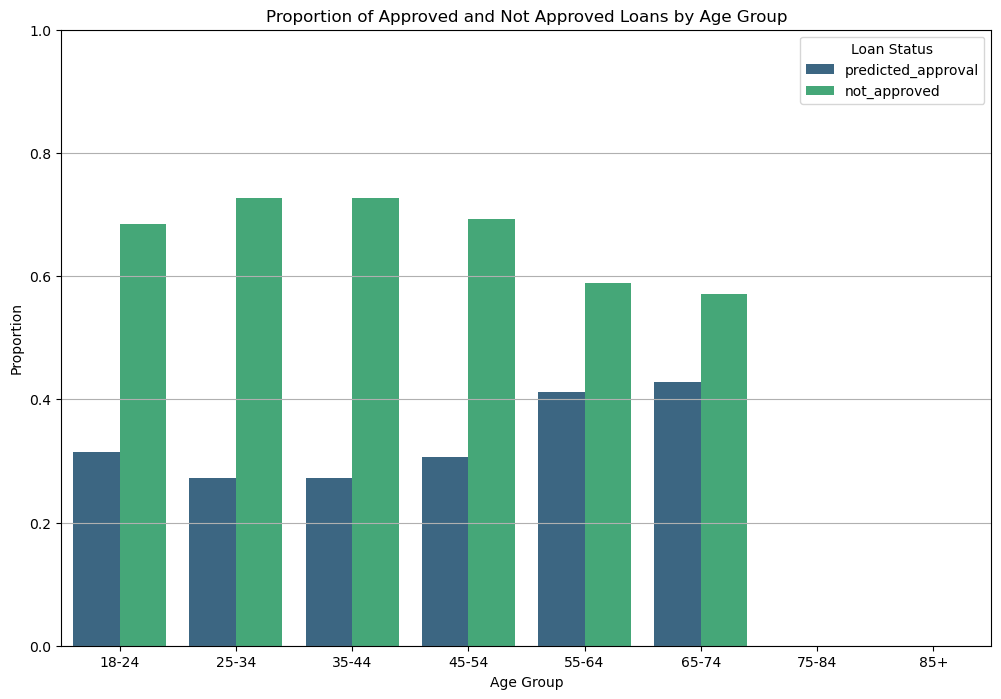

In [102]:
df_test['predicted_approval'] = y_pred

# Define age groups
bins = [18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85+']
df_test['age_group'] = pd.cut(df_test['person_age'], bins=bins, labels=labels, right=False)

# Calculate the proportion of approvals and not approvals in each age group
approval_rates = df_test.groupby('age_group')['predicted_approval'].mean().reset_index()
approval_rates['not_approved'] = 1 - approval_rates['predicted_approval']
approval_rates = approval_rates.melt(id_vars='age_group', var_name='Status', value_name='Proportion')

# Plot the stacked bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='age_group', y='Proportion', hue='Status', data=approval_rates, palette='viridis')
plt.xlabel('Age Group')
plt.ylabel('Proportion')
plt.title('Proportion of Approved and Not Approved Loans by Age Group')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

Based on this visual, we see that under our proposed system, older individuals are more likely to be approved for a loan, more specifically, the age group 65-74 has the highest approval rate while the age group 25-34 has the lowest approval rate.

### Question 2: Loan Intent and Default Rate

To answer this question, we will calculate the proportion of people in each loan intent group who are approved for a loan under our proposed system and compare it to the actual approval rate in that group:

In [103]:
intent_loans = (1-df_test.groupby(['loan_intent']).agg({'loan_status':'mean', 'y_pred':'mean'})).reset_index().rename({'loan_status':'actual', 'y_pred':'predicted'}, axis = 1)
intent_loans['difference'] = intent_loans['predicted'] - intent_loans['actual']
intent_loans

,loan_intent,actual,predicted,difference
0,DEBTCONSOLIDATION,0.712389,0.689159,-0.023230
1,EDUCATION,0.832483,0.709184,-0.123299
2,HOMEIMPROVEMENT,0.750000,0.767857,0.017857
3,MEDICAL,0.715750,0.692451,-0.023299
4,PERSONAL,0.779559,0.701403,-0.078156
5,VENTURE,0.853734,0.723029,-0.130705


Based on this table, we see that `VENTURE` has the lowest approval rate under our proposed system from reality while `HOMEIMPROVEMENT` is the only loan intent group that has a higher approval rate under our proposed system than in reality.

### Question 3: Income Level and Access to Credit

To answer this question, we will calculate the proportion of people in each income level group who are approved for a loan under our proposed system:

/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc0000gn/T/ipykernel_14463/2154731516.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_approval_rates = df_test.groupby('income_group')['predicted_approval'].apply(lambda x: .9 - x.mean()).reset_index()
/Users/donovanwood/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


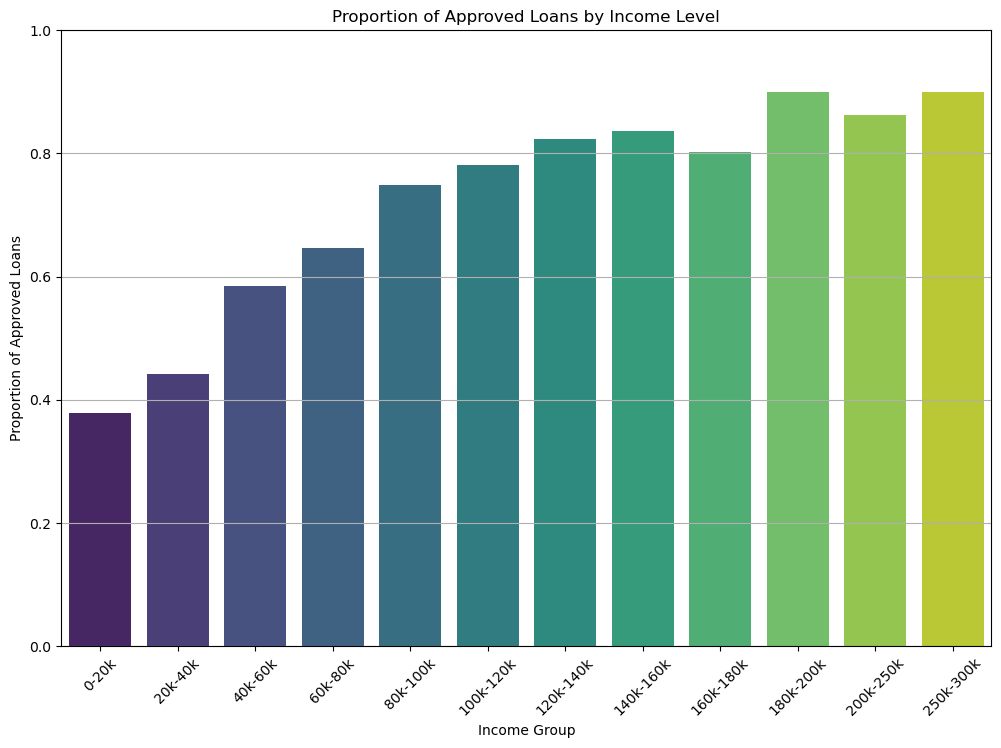

In [108]:
income_bins = [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 250000, 300000]
income_labels = ['0-20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k-120k', '120k-140k', '140k-160k', '160k-180k', '180k-200k', '200k-250k', '250k-300k']
df_test['income_group'] = pd.cut(df_test['person_income'], bins=income_bins, labels=income_labels, right=False)

# Calculate the proportion of approvals in each income group
income_approval_rates = df_test.groupby('income_group')['predicted_approval'].apply(lambda x: .9 - x.mean()).reset_index()

# Plot the proportions
plt.figure(figsize=(12, 8))
sns.barplot(x='income_group', y='predicted_approval', data=income_approval_rates, palette='viridis')
plt.xlabel('Income Group')
plt.ylabel('Proportion of Approved Loans')
plt.title('Proportion of Approved Loans by Income Level')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

From this figure, we can see that the higher the income level, the more likely it will be for an individual to be approved for a loan under our proposed system. This is a good sign as it shows that our model is working well and is able to predict the likelihood of defaulting on a loan based on income level. This is similar to what we find in real life. 

# Conclusion

In conclusion, we have built a logistic regression model that predicts whether a prospective borrower is likely to default on a given loan. We have evaluated the model from both the bank's perspective and the borrower's perspective. We found that our model is able to predict the likelihood of defaulting on a loan with an expected profit per loan of `$1717.02`. We also found that older individuals are more likely to be approved for a loan under our proposed system, `HOMEIMPROVEMENT` has the highest approval rate under our proposed system, and the higher the income level, the more likely it will be for an individual to be approved for a loan under our proposed system. From this Blog Post I learned how to build a logistic regression model and evaluate it from both the bank's perspective and the borrower's perspective. I learned that it is important to consider both perspectives when building a model and that although a model can find the most profitable loans for a bank, it is also important to consider the impact on the borrower as these are real people with real complications. 

For me personally, fairness means that everyone has an equal opportunity to do a particular action that is should not be restricted by unchangeable characteristics.